In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

root_path = 'gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Framingham/'

print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Deep Learning Labs/Framingham/


In [ ]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, auc

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv(os.path.join(root_path, "framingham.csv"))


print("Ukuran dataset:", df.shape)
print("\nJumlah missing value per kolom:\n", df.isnull().sum())


print("\nInfo dataset:")
print(df.info())

if "TenYearCHD" in df.columns:
    print("\nDistribusi label target (TenYearCHD):")
    print(df["TenYearCHD"].value_counts(normalize=True))


Ukuran dataset: (4240, 16)

Jumlah missing value per kolom:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     

In [ ]:

from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

imputer_num = SimpleImputer(strategy="median")
df[num_cols] = imputer_num.fit_transform(df[num_cols])

if len(cat_cols) > 0:
    imputer_cat = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("Jumlah missing value setelah imputasi:\n", df.isnull().sum().sum())

Jumlah missing value setelah imputasi:
 0


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop("TenYearCHD", axis=1)
y = df["TenYearCHD"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
)

print("Distribusi kelas di train:", np.bincount(y_train))
print("Distribusi kelas di test :", np.bincount(y_test))


Distribusi kelas di train: [2517  451]
Distribusi kelas di test : [1079  193]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
print("Jumlah sebelum SMOTE-IPF:", X_train.shape, np.bincount(y_train))

Jumlah sebelum SMOTE-IPF: (2968, 15) [2517  451]


In [ ]:
svm = SVC(kernel='rbf', C=100, gamma=0.001, class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)

print("Classification Report Tanpa SMOTE-IPF:\n", classification_report(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))


Classification Report Tanpa SMOTE-IPF:
               precision    recall  f1-score   support

         0.0       0.91      0.68      0.78      1079
         1.0       0.26      0.62      0.36       193

    accuracy                           0.67      1272
   macro avg       0.58      0.65      0.57      1272
weighted avg       0.81      0.67      0.71      1272

F1-Score: 0.36199095022624433


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5)
pipeline_svm = Pipeline([("scaler", StandardScaler()), ("svm", SVC())])
scores = cross_val_score(pipeline_svm, X, y, cv=cv, scoring="f1")
print("Rata-rata F1-Score CV (tanpa SMOTE-IPF):", scores.mean())

Rata-rata F1-Score CV (tanpa SMOTE-IPF): 0.03550355033506989


In [ ]:
import numpy as np
smote = SMOTE(sampling_strategy=0.5,
    random_state=42,
    k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Jumlah setelah SMOTE:", X_resampled.shape, np.bincount(y_resampled))


svm_smote = SVC(kernel='rbf', C=100, gamma=0.001, class_weight='balanced', probability=True, random_state=42)
svm_smote.fit(X_resampled, y_resampled)
y_pred_smote = svm_smote.predict(X_test_scaled)

print("\nClassification Report dengan SMOTE Tanpa IPF:\n", classification_report(y_test, y_pred_smote))
print("F1-Score (dengan SMOTE Tanpa IPF):", f1_score(y_test, y_pred_smote))


pipeline_smote_svm = ImbPipeline([("scaler", StandardScaler()), ("smote", SMOTE(random_state=42)), ("svm", SVC())])
scores_smote = cross_val_score(pipeline_smote_svm, X, y, cv=cv, scoring="f1")
print("\nRata-rata F1-Score CV (dengan SMOTE Tanpa IPF):", scores_smote.mean())

Jumlah setelah SMOTE: (3775, 15) [2517 1258]

Classification Report dengan SMOTE Tanpa IPF:
               precision    recall  f1-score   support

         0.0       0.91      0.67      0.77      1079
         1.0       0.26      0.64      0.36       193

    accuracy                           0.66      1272
   macro avg       0.58      0.65      0.57      1272
weighted avg       0.81      0.66      0.71      1272

F1-Score (dengan SMOTE Tanpa IPF): 0.36444444444444446

Rata-rata F1-Score CV (dengan SMOTE Tanpa IPF): 0.32584346671485515


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

class SMOTE_IPF(BaseEstimator):

    def __init__(self, smote_k=5, ipf_k=3, max_iter=5, sampling_strategy=0.5,
                 random_state=None, verbose=False, remove_only_synthetic=True):
        self.smote_k = smote_k
        self.ipf_k = ipf_k
        self.max_iter = max_iter
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.verbose = verbose
        self.remove_only_synthetic = remove_only_synthetic

    def fit_resample(self, X, y):

        X = np.asarray(X)
        y = np.asarray(y).astype(int).ravel()

        n_orig = X.shape[0]


        smote = SMOTE(k_neighbors=self.smote_k,
                      sampling_strategy=self.sampling_strategy,
                      random_state=self.random_state)

        X_res, y_res = smote.fit_resample(X, y)


        n_after_smote = X_res.shape[0]
        n_synthetic = n_after_smote - n_orig
        synthetic_mask = np.zeros(n_after_smote, dtype=bool)
        if n_synthetic > 0:
            synthetic_mask[n_orig:] = True


        data = np.hstack((X_res.copy(), y_res.reshape(-1, 1)))

        if self.verbose:
            unique, counts = np.unique(y_res, return_counts=True)
            print(f"[SMOTE] before IPF: total={data.shape[0]}, class_dist={dict(zip(unique, counts))}, synthetic={n_synthetic}")


        for i in range(self.max_iter):
            clf = KNeighborsClassifier(n_neighbors=max(1, self.ipf_k))
            X_curr = data[:, :-1]
            y_curr = data[:, -1]

            clf.fit(X_curr, y_curr)
            y_pred = clf.predict(X_curr)

            misclassified = (y_pred != y_curr)

            if not np.any(misclassified):
                if self.verbose:
                    print(f"[IPF] iter {i+1}: no misclassified samples -> stop")
                break

            if self.remove_only_synthetic:

                current_len = data.shape[0]

                current_synthetic_mask = np.zeros(current_len, dtype=bool)
                if current_len > n_orig:
                    current_synthetic_mask[n_orig:current_len] = True

                removable = misclassified & current_synthetic_mask
                removed_count = removable.sum()


                if removed_count == 0:
                    if self.verbose:
                        print(f"[IPF] iter {i+1}: misclassified mostly original samples -> stop to avoid removing originals")
                    break

                data = data[~removable]

            else:

                removed_count = misclassified.sum()
                data = data[~misclassified]

            if self.verbose:
                unique, counts = np.unique(data[:, -1], return_counts=True)
                print(f"[IPF] iter {i+1}: removed={removed_count}, remain_total={data.shape[0]}, class_dist={dict(zip(unique, counts))}")

        X_final = data[:, :-1]
        y_final = data[:, -1].astype(int)

        if self.verbose:
            unique, counts = np.unique(y_final, return_counts=True)
            print(f"[SMOTE-IPF] final: total={X_final.shape[0]}, class_dist={dict(zip(unique, counts))}")

        return X_final, y_final

In [ ]:
smote_ipf = SMOTE_IPF(smote_k=5, ipf_k=3, max_iter=5)
X_resampled, y_resampled = smote_ipf.fit_resample(X_train_scaled, y_train)


In [ ]:
print("Jumlah sesudah SMOTE-IPF:", X_resampled.shape, np.bincount(y_resampled))

Jumlah sesudah SMOTE-IPF: (3771, 15) [2517 1254]


In [ ]:
svm_resampled = SVC(kernel='rbf', C=100, gamma=0.001, class_weight='balanced', probability=True, random_state=42)
svm_resampled.fit(X_resampled, y_resampled)
y_pred_resampled = svm_resampled.predict(X_test_scaled)

print("Classification Report dengan SMOTE-IPF:\n", classification_report(y_test, y_pred_resampled))
print("F1-Score:", f1_score(y_test, y_pred_resampled))


Classification Report dengan SMOTE-IPF:
               precision    recall  f1-score   support

         0.0       0.91      0.65      0.76      1079
         1.0       0.25      0.64      0.36       193

    accuracy                           0.65      1272
   macro avg       0.58      0.65      0.56      1272
weighted avg       0.81      0.65      0.70      1272

F1-Score: 0.3565217391304348


In [ ]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb

pipeline_resampled = make_pipeline_imb(StandardScaler(), SMOTE_IPF(), SVC())
scores_resampled = cross_val_score(pipeline_resampled, X, y, cv=cv, scoring="f1")
print("Rata-rata F1-Score CV (dengan SMOTE-IPF):", scores_resampled.mean())


Rata-rata F1-Score CV (dengan SMOTE-IPF): 0.26631155786124794


=== Summary (Test set) ===
Baseline SVM       : Accuracy = 0.850, F1(pos=1) = 0.050
SVM + SMOTE        : Accuracy = 0.679, F1(pos=1) = 0.322
SVM + SMOTE-IPF    : Accuracy = 0.793, F1(pos=1) = 0.306

(Kamu juga bisa lihat classification_report/confusion_matrix tiap model bila perlu.)


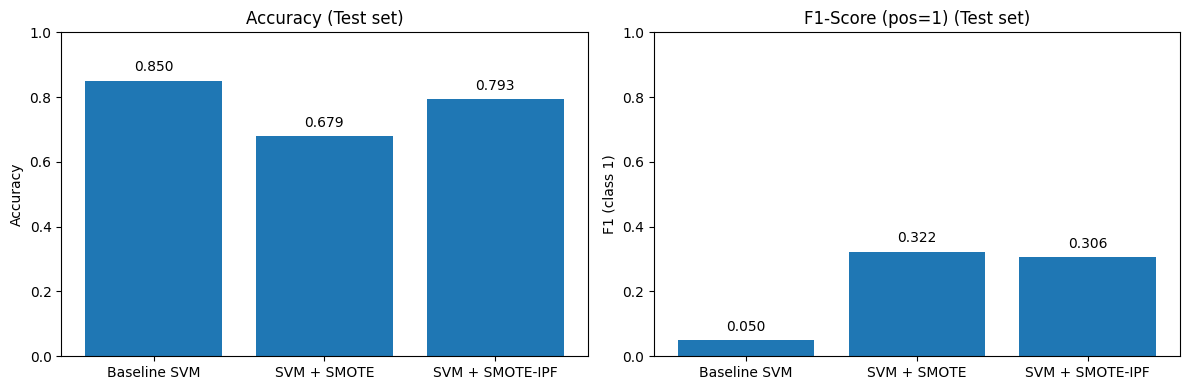

In [ ]:
# Cell: bandingkan & visualisasi (Accuracy + F1 pos=1) untuk 3 skenario
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# ---------- 1) Baseline (SVM tanpa resampling) ----------
svm_base = SVC(random_state=42)          # gunakan parameter yang konsisten untuk semua model
svm_base.fit(X_train_scaled, y_train)
y_base = svm_base.predict(X_test_scaled)
acc_base = accuracy_score(y_test, y_base)
f1_base = f1_score(y_test, y_base, pos_label=1)

# ---------- 2) SVM + SMOTE ----------
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

svm_smote = SVC(random_state=42)
svm_smote.fit(X_smote, y_smote)
y_sm = svm_smote.predict(X_test_scaled)
acc_smote = accuracy_score(y_test, y_sm)
f1_smote = f1_score(y_test, y_sm, pos_label=1)

# ---------- 3) SVM + SMOTE-IPF ----------
# make sure SMOTE_IPF class is defined earlier and returns arrays
smote_ipf = SMOTE_IPF(smote_k=5, ipf_k=3, max_iter=5, random_state=42, verbose=False, remove_only_synthetic=True)
X_ipf, y_ipf = smote_ipf.fit_resample(X_train_scaled, y_train)

svm_ipf = SVC(random_state=42)
svm_ipf.fit(X_ipf, y_ipf)
y_ip = svm_ipf.predict(X_test_scaled)
acc_ipf = accuracy_score(y_test, y_ip)
f1_ipf = f1_score(y_test, y_ip, pos_label=1)

# ---------- Print ringkasan angka (opsional) ----------
print("=== Summary (Test set) ===")
print(f"Baseline SVM       : Accuracy = {acc_base:.3f}, F1(pos=1) = {f1_base:.3f}")
print(f"SVM + SMOTE        : Accuracy = {acc_smote:.3f}, F1(pos=1) = {f1_smote:.3f}")
print(f"SVM + SMOTE-IPF    : Accuracy = {acc_ipf:.3f}, F1(pos=1) = {f1_ipf:.3f}")
print("\n(Kamu juga bisa lihat classification_report/confusion_matrix tiap model bila perlu.)")

# ---------- Visualisasi: dua bar charts terpisah ----------
models = ["Baseline SVM", "SVM + SMOTE", "SVM + SMOTE-IPF"]
accs = [acc_base, acc_smote, acc_ipf]
f1s = [f1_base, f1_smote, f1_ipf]

# Figure dengan 2 subplots vertikal (Accuracy, F1)
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Accuracy bar chart
ax = axes[0]
bars = ax.bar(models, accs)
ax.set_title("Accuracy (Test set)")
ax.set_ylim(0,1)
ax.set_ylabel("Accuracy")
for bar, val in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.3f}", ha="center", va="bottom")

# F1 bar chart
ax = axes[1]
bars = ax.bar(models, f1s)
ax.set_title("F1-Score (pos=1) (Test set)")
ax.set_ylim(0,1)
ax.set_ylabel("F1 (class 1)")
for bar, val in zip(bars, f1s):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


== Baseline SVM ==
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      1079
         1.0       0.62      0.03      0.05       193

    accuracy                           0.85      1272
   macro avg       0.74      0.51      0.48      1272
weighted avg       0.82      0.85      0.79      1272

Confusion matrix:
 [[1076    3]
 [ 188    5]]
Accuracy: 0.8498  |  F1 (pos=1): 0.0498

== SVM + SMOTE ==
              precision    recall  f1-score   support

         0.0       0.91      0.67      0.77      1079
         1.0       0.26      0.64      0.36       193

    accuracy                           0.66      1272
   macro avg       0.58      0.65      0.57      1272
weighted avg       0.81      0.66      0.71      1272

Confusion matrix:
 [[720 359]
 [ 70 123]]
Accuracy: 0.6627  |  F1 (pos=1): 0.3644

== SVM + SMOTE-IPF ==
              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79      1079
        

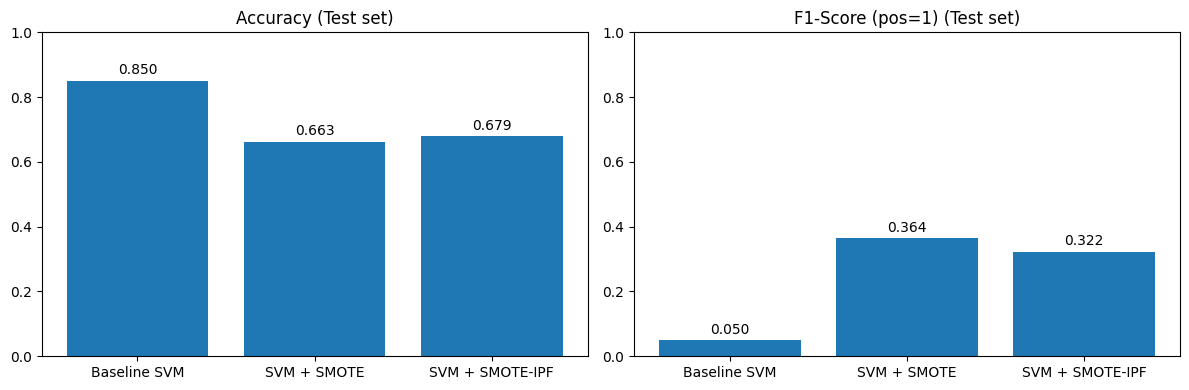

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def eval_on_test(model, X_test_scaled, y_test, name):
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1_pos = f1_score(y_test, y_pred, pos_label=1)
    print(f"== {name} ==")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {acc:.4f}  |  F1 (pos=1): {f1_pos:.4f}\n")
    return acc, f1_pos


try:
    svm_base
except NameError:
    from sklearn.svm import SVC
    svm_base = SVC(random_state=42)
    svm_base.fit(X_train_scaled, y_train)

acc_base, f1_base = eval_on_test(svm_base, X_test_scaled, y_test, "Baseline SVM")


try:
    svm_smote
except NameError:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
    svm_smote = SVC(random_state=42)
    svm_smote.fit(X_smote, y_smote)

acc_smote, f1_smote = eval_on_test(svm_smote, X_test_scaled, y_test, "SVM + SMOTE")


try:
    svm_ipf
except NameError:

    try:
        X_ipf, y_ipf
    except NameError:
        smote_ipf = SMOTE_IPF(smote_k=5, ipf_k=3, max_iter=5, random_state=42, verbose=False, remove_only_synthetic=True)
        X_ipf, y_ipf = smote_ipf.fit_resample(X_train_scaled, y_train)
    svm_ipf = SVC(random_state=42)
    svm_ipf.fit(X_ipf, y_ipf)

acc_ipf, f1_ipf = eval_on_test(svm_ipf, X_test_scaled, y_test, "SVM + SMOTE-IPF")

models = ["Baseline SVM", "SVM + SMOTE", "SVM + SMOTE-IPF"]
accs = [acc_base, acc_smote, acc_ipf]
f1s = [f1_base, f1_smote, f1_ipf]

fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
bars = ax.bar(models, accs)
ax.set_ylim(0,1)
ax.set_title("Accuracy (Test set)")
for bar, val in zip(bars, accs):
    ax.text(bar.get_x()+bar.get_width()/2, val+0.02, f"{val:.3f}", ha="center")
ax = axes[1]
bars = ax.bar(models, f1s)
ax.set_ylim(0,1)
ax.set_title("F1-Score (pos=1) (Test set)")
for bar, val in zip(bars, f1s):
    ax.text(bar.get_x()+bar.get_width()/2, val+0.02, f"{val:.3f}", ha="center")
plt.tight_layout()
plt.show()
